[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

# Plant Classification-Histogram Equalization (CLAHE)-2

## Instructions
1. Clone the repository.
2. Download the necessary datasets from Eden Repository:
   1. Black nightsade-22/MAY/2019-v1
3. Unzip dataset files and remove the zip files.
4. Create a folder called 'eden_data'.
5. Move the unzipped datasets into this folder.
6. The resulting directory structure should be something similar to:
    * eden_library_notebooks/image_preprocessing/
       * plant_classification-histogram_equalization-1.ipynb
       * eden_data/
           * Black nightsade-220519-Weed-zz-V1-...
7. Install notebook dependencies by running:
    <pre><code>conda env create -f eden_histogram_equalization.yml</code></pre>
8. Open the notebook: jupyter notebook
9. Run the code

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will reply to you as soon as possible.

### Background

This notebook is based on the **Plant Classification-Histogram Equalization-1** notebook which displayed some simple image processing techniques, mainly Histogram equalization, and expands on it by presenting the Contrast Limited Adaptive Histogram Equalization (CLAHE) technique. Many other techniques could be found in the notebooks published in the <a href="http://edenlibrary.ai/">Eden Library platform</a>. Take a look!!

**Contrast** describes the pixel brightness distribution in an image. In the case of over-/underexposure or low contrast, where pixel intensities have very sharp distributions, distinguishing certain features in an image can become challenging, both for human and machine readers. 

Whereas regular histogram equalization transforms the whole image on a single transfer function, **CLAHE** uses local transfer functions for each individual pixel, improving contrast in smaller areas with more extreme values. CLAHE uses two parameters: *Grid Size* and *Clip Limit*. Grid Size sets the neighborhood of NxN pixels around each image pixel for which the local histogram equalization is performed (See left side of the figure). Clip Limit sets the threshold at which to clip the histogram before computing the cumulative distribution function, reducing noise amplification (See right side of the figure).<p><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/AHE-neighbourhoods.svg/300px-AHE-neighbourhoods.svg.png" width='150'>&nbsp;&nbsp;&nbsp;<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/Clahe-redist.svg/300px-Clahe-redist.svg.png" width='270'>
    
Histogram Equalization on multi-channel images (3D arrays) can be performed in various ways. In the previous notebook, we performed the technique on each individual channel, and then merged them together into a single image, which may improve the contrast but may not retain color balance. Here we present a technique of transforming the image from RGB to another **color space** (HSV/LAB/etc.) and performing histogram equalization only on the luminance channel. This way, we should be able to better preserve the initial color balance, in theory at least.

#### Library imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm
from glob import glob
import random

#### Auxiliar functions

In [2]:
def plot_sample(X):
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))

    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(X[random.randint(0, X.shape[0])-1])

In [3]:
def read_data(path, im_size=(128,128)):
    
    X = []
    
    for im_file in tqdm(glob(path + "*/*")):
        try:
            im = cv2.imread(im_file)
            im = cv2.resize(im, im_size)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            X.append(im)
        except Exception as e:
            # In case annotations or metadata are found
            print("Not a picture")
    
    X = np.array(X)
    
    return X

#### Auxiliar functions for computing and displaying histograms

In [4]:
def plot_channel_histogram(image, ax):
    hist, bins = np.histogram(image.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()
    ax.plot(cdf_normalized, color = 'b')
    ax.hist(image.flatten(),256,[0,256], color = 'r')
    ax.legend(('cdf','histogram'), loc = 'upper left')
    
def plot_image_histogram(image, ax):
    color = ('r','g','b')
    for i, col in enumerate(color):
        histr = cv2.calcHist([image],[i],None,[256],[0,256])
        ax.plot(histr,color = col)

#### Experimental constants

In [5]:
IM_SIZE = (256, 256)
IM_PATH = 'eden_data/' # Path to the Eden data

#### Reading and displaying pictures
Some of the pictures inside this dataset are **overexposed**. Therefore, we will use histogram equalization to improve the image quality. 

100%|██████████| 123/123 [00:21<00:00,  5.78it/s]


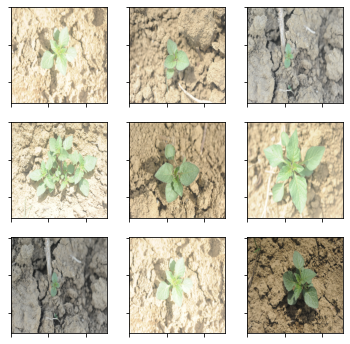

In [6]:
#set the image name
X = read_data(IM_PATH, IM_SIZE)
plot_sample(X)

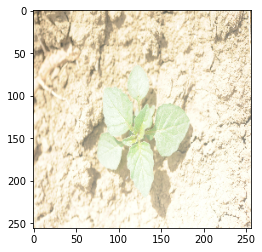

In [7]:
SAMPLE_IMAGE_INDEX = 122
im_sample = X[SAMPLE_IMAGE_INDEX]
plt.imshow(im_sample)
plt.show()

### 1. Grayscale image
In this first example, we will work with a grayscale version of the picture. In other words, only 1 channel is going to be equalized.

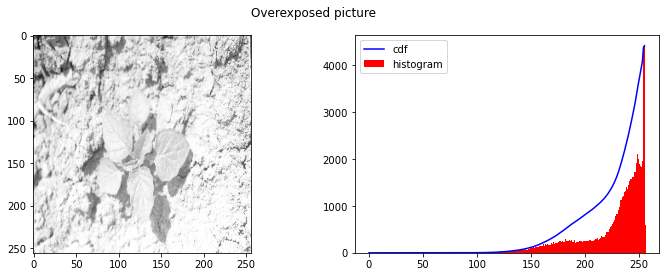

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('Overexposed picture')
# Transform RGB image into a grayscale version
gray = cv2.cvtColor(im_sample, cv2.COLOR_RGB2GRAY)
ax1.imshow(gray, cmap="gray")
plot_channel_histogram(gray, ax2)
plt.show()

The CLAHE technique which will be applied to the above grayscale image requires us to set two parameters, CLIP_LIMIT and GRID_SIZE. Since we are unsure about their optimal values, we will make a parameter grid of three values of each and plot their histograms. This way, we will be able to see how each parameter affects the contrast and noise of each image, and select the best values combination for further experimentation.

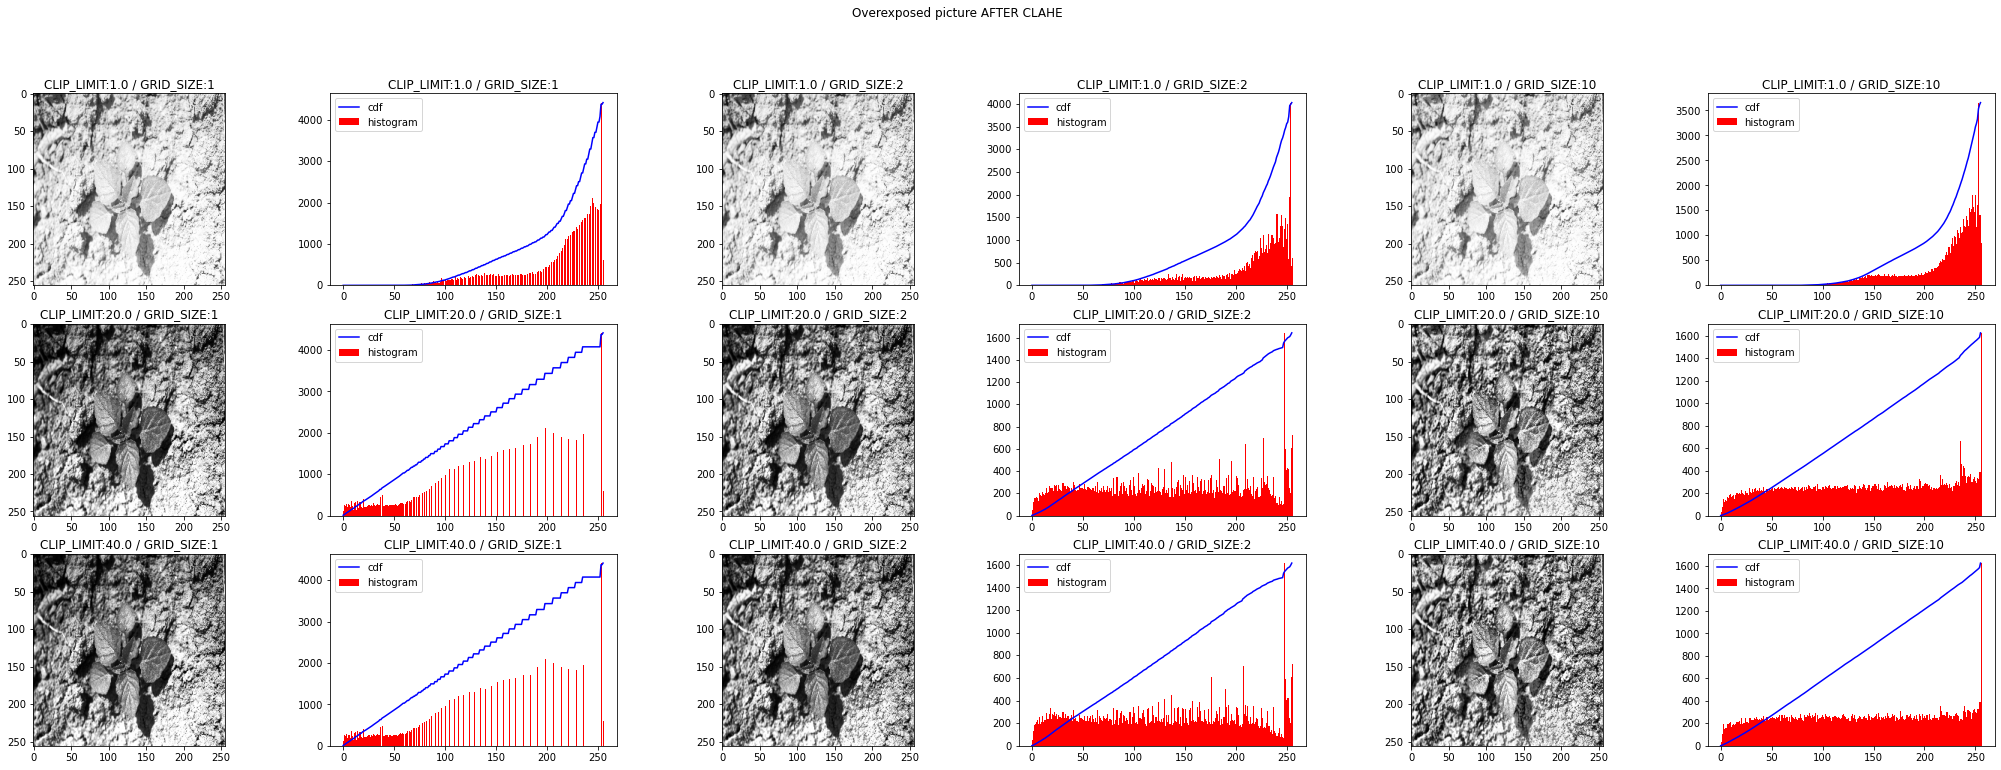

In [9]:
#### This parameter sets the threshold for contrast limiting. The default value is 40.
CLIP_LIMIT = [1.0, 20.0, 40.0]
len_CL = len(CLIP_LIMIT)

# This sets the number of tiles in the row and column. By default this is 8×8. It is used while the image is divided into tiles for applying CLAHE.
GRID_SIZE = [1, 2, 10]
len_GS = len(GRID_SIZE)

fig, axs = plt.subplots(len_CL, len_GS*2, figsize=(len_GS*12,len_CL*4))
fig.suptitle('Overexposed picture AFTER CLAHE')

# Equalizing grayscale images
for i in range(len_CL):
    for j in range(len_GS):
        clahe = cv2.createCLAHE(clipLimit=CLIP_LIMIT[i], tileGridSize=(GRID_SIZE[j],GRID_SIZE[j]))
        equ = clahe.apply(gray)
        axs[i][2*j].imshow(equ, cmap="gray")
        plot_channel_histogram(equ, axs[i][2*j+1])

        axs[i][2*j].set_title("CLIP_LIMIT:" + str(CLIP_LIMIT[i]) + " / GRID_SIZE:" + str(GRID_SIZE[j]))
        axs[i][2*j+1].set_title("CLIP_LIMIT:" + str(CLIP_LIMIT[i]) + " / GRID_SIZE:" + str(GRID_SIZE[j]))
        
plt.show()

From the above diagram grid we can see that using a clip limit value of 20.0 and above gives us the flattest distribution of pixel brightness across the image and, therefore, the highest contrast. Also, the greater the grid size value selected, the more contrast of smaller areas is amplified, resulting in images where the main subject may not be easily discernible anymore.

In the following examples we shall use clip limit 20.0 and grid size 2x2 as a baseline.

### 2. Multi-channel image (RGB)

In this second example, we will work with the original RGB version of the picture. For that reason, each of the 3 channels will be equalized separately using CLAHE.

#### Original Image

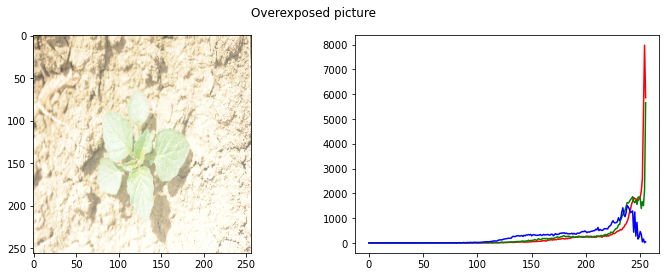

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('Overexposed picture')
ax1.imshow(im_sample)

plot_image_histogram(im_sample, ax2)

plt.show()

##### Algorithm
To perform histogram equalization on a multi-channel image it is necessary to: 
1. Split the image into its respective channels
2. Equalize each channel, and
3. Merge the channels back together.

In [11]:
NUM_CHANNELS = 3
# Algorithm: Steps 1 and 2
eqs = [cv2.createCLAHE(clipLimit=20.0, tileGridSize=(2,2)).apply(im_sample[:,:,i])[:,:,np.newaxis] for i in range(NUM_CHANNELS)]
# Algorithm: Step 3
equalized_image = cv2.merge((eqs[0], eqs[1], eqs[2]))

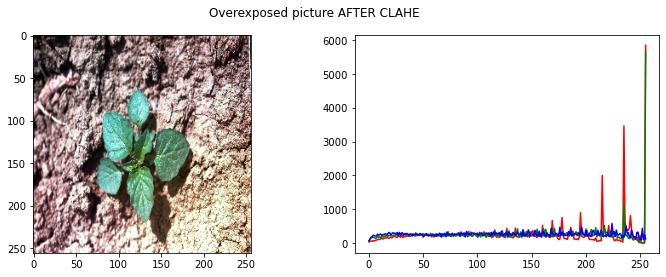

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('Overexposed picture AFTER CLAHE')
ax1.imshow(equalized_image)

plot_image_histogram(equalized_image, ax2)
plt.show()

#### CLAHE & Color Space Transformation (RGB > HSV)

In the following module, we transform the original image from RGB (Reg/Green/Blue) to the HSV (Hue/Saturation/Value) color space, where Value represents the luminance of each pixel. By performing CLAHE equalization only on the brightness of the image, we are more likely to preserve its initial color balance.

In [13]:
def show_hsv_equalized(image):
    H, S, V = cv2.split(cv2.cvtColor(image, cv2.COLOR_RGB2HSV))
    clahe = cv2.createCLAHE(clipLimit=20.0, tileGridSize=(2,2))
    eqV = clahe.apply(V)
    return cv2.cvtColor(cv2.merge([H, S, eqV]), cv2.COLOR_HSV2RGB)

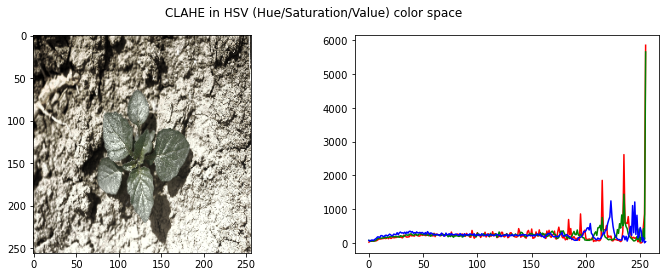

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('CLAHE in HSV (Hue/Saturation/Value) color space')
ax1.imshow(show_hsv_equalized(im_sample))

plot_image_histogram(show_hsv_equalized(im_sample), ax2)
plt.show()

## Possible Extensions
1. Examine histogram equalization with/out CLAHE in LAB (Lightness/green–red/blue–yellow) color space.
2. Examine histogram equalization on only 1 or 2 channels of multi-channel images.

## Bibliography

https://docs.opencv.org/3.4/d6/db6/classcv_1_1CLAHE.html

https://en.wikipedia.org/wiki/Adaptive_histogram_equalization#CLAHE

https://www.pyimagesearch.com/2021/02/01/opencv-histogram-equalization-and-adaptive-histogram-equalization-clahe/

https://medium.com/@kyawsawhtoon/a-tutorial-to-histogram-equalization-497600f270e2

https://medium.com/@rndayala/image-histograms-in-opencv-40ee5969a3b7

https://ieeexplore.ieee.org/document/1257395?arnumber=1257395